In [3]:
!pip install -r ../requirements.txt

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.9/68.9 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached openml-0.14.2-py3-none-any.whl
  Using cached liac_arff-2.5.0-py3-none-any.whl
  Using cached xmltodict-0.13.0-py2.py3-none-any.whl.metadata (7.7 kB)
  Using cached minio-7.2.7-py3-none-any.whl.metadata (6.4 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.4/68.4 kB 10.9 MB/s eta 0:00:00
  Using cached pycryptodome-3.20.0-cp35-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.4 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 13.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.7/112.7 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 16.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6

In [51]:
!pip install fastparquet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 24.7 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 89.7 MB/s eta 0:00:00


In [1]:
# confirm TensorFlow sees the GPU
from tensorflow.python.client import device_lib

assert "GPU" in str(device_lib.list_local_devices())

# confirm PyTorch sees the GPU
from torch import cuda

assert cuda.is_available()
assert cuda.device_count() > 0

2024-08-05 07:07:53.925094: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-05 07:07:55.068965: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64:/usr/lib/x86_64-linux-gnu/:/opt/conda/lib
2024-08-05 07:07:55.069146: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local

Tesla T4


In [1]:
import time

import numpy as np
import scipy
from common import hpo_space
from keras import backend as K
from keras.callbacks import Callback, EarlyStopping
from keras.datasets.mnist import load_data
from keras.models import Model
from keras.utils import set_random_seed
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from src.config import Config
from src.data import Dataset
from src.util import get_model, get_random_hyperparams

2024-08-08 03:37:43.445887: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-08 03:38:10.477928: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64:/usr/lib/x86_64-linux-gnu/:/opt/conda/lib
2024-08-08 03:38:10.479620: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local

In [2]:
import tensorflow as tf

device = tf.config.list_physical_devices("GPU")[0]
tf.config.experimental.set_memory_growth(device, True)

2024-08-08 03:38:30.949743: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-08 03:38:35.883597: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-08 03:38:35.884108: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [3]:
def get_mnist():
    return load_data()


def get_svhn():
    train_data = scipy.io.loadmat("train_32x32.mat")
    x_train = train_data["X"]
    y_train = train_data["y"]
    test_data = scipy.io.loadmat("test_32x32.mat")
    x_test = test_data["X"]
    y_test = test_data["y"]

    x_train = np.moveaxis(x_train, -1, 0)
    x_test = np.moveaxis(x_test, -1, 0)

    return (x_train, y_train), (x_test, y_test)


def get_data(dataset: str="svhn"):
    data_loaders = {
        "mnist": (get_mnist, (28, 28, 1)),
        "svhn": (get_svhn, (32, 32, 3))
    }

    if dataset not in data_loaders:
        msg = "Invalid dataset name."
        raise ValueError(msg)

    data_loader, (img_rows, img_cols, img_channels) = data_loaders[dataset]
    (x_train, y_train), (x_test, y_test) = data_loader()

    x_train = x_train.astype("float32")
    x_test = x_test.astype("float32")
    x_train /= 255
    x_test /= 255

    if K.image_data_format() == "channels_first":
        x_train = x_train.reshape(x_train.shape[0], img_channels, img_rows, img_cols)
        x_test = x_test.reshape(x_test.shape[0], img_channels, img_rows, img_cols)
    else:
        x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, img_channels)
        x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, img_channels)

    lb = LabelBinarizer()
    y_train = lb.fit_transform(y_train)
    y_test = lb.transform(y_test)
    return Dataset(x_train, y_train, x_test, y_test)

In [4]:
def get_convexity(model: Model, data: Dataset, config: Config):
    BATCH_SIZE = config.batch_size

    def Ka_func(xb):
        _model = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)
        return _model(xb)

    best_mu = -np.inf
    for i in range((len(data.x_train) - 1) // BATCH_SIZE + 1):
        start_i = i * BATCH_SIZE
        end_i = start_i + BATCH_SIZE
        xb = data.x_train[start_i:end_i]

        mu = np.linalg.norm(Ka_func([xb])) / np.linalg.norm(model.layers[-1].weights[0])
        if mu > best_mu and mu != np.inf:
            best_mu = mu

    return best_mu

In [5]:
class FlatnessCallback(Callback):
    def __init__(self, model: Model, dataset: Dataset, config: Config) -> None:
        super().__init__()
        self.model = model
        self.dataset = dataset
        self.config = config
        self.mus = []

    def on_epoch_end(self, epoch, logs=None) -> None:
        mu = get_convexity(self.model, self.dataset, self.config)
        self.mus.append(mu)

In [6]:
def run_experiment(dataset: str, config: Config):
    data = get_data(dataset)
    time.time()

    if isinstance(config, dict):
        config = Config(**config)

    model = get_model(data, config)

    early_stop = EarlyStopping(monitor="loss", patience=5, min_delta=1e-3)
    flatness_cb = FlatnessCallback(model, data, config)
    history = model.fit(data.x_train, data.y_train, batch_size=int(config.batch_size), validation_split=0.2, epochs=100, callbacks=[early_stop, flatness_cb], verbose=1)

    time.time()

    del data
    del model

    return history.history, flatness_cb.mus

In [7]:
# Need to reseed each time, otherwise config changes
set_random_seed(13)

config = get_random_hyperparams(hpo_space)

Config(batch_size=128, n_filters=4, kernel_size=3, padding='valid', n_blocks=3, dropout_rate=0.24414797545052536, final_dropout_rate=0.2675488806686338, n_units=64)


In [8]:
import functools
import gc
import operator

gc.collect()

0

Running svhn


2024-08-08 03:38:41.721961: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-08 03:38:41.801156: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-08 03:38:41.801613: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-08 03:38:41.801994: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least on

Epoch 1/100


2024-08-08 03:38:54.260608: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8900
2024-08-08 03:39:05.348390: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x55611fe5d420 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-08-08 03:39:05.348444: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
2024-08-08 03:39:06.404607: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-08 03:39:11.720246: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


458/458 [==============================] - 37s 24ms/step - loss: 2.0041 - accuracy: 0.2991 - val_loss: 1.6505 - val_accuracy: 0.4354
Epoch 2/100
458/458 [==============================] - 10s 21ms/step - loss: 1.5574 - accuracy: 0.4785 - val_loss: 1.4802 - val_accuracy: 0.5187
Epoch 3/100
458/458 [==============================] - 10s 21ms/step - loss: 1.4329 - accuracy: 0.5270 - val_loss: 1.3776 - val_accuracy: 0.5552
Epoch 4/100
458/458 [==============================] - 10s 22ms/step - loss: 1.3571 - accuracy: 0.5561 - val_loss: 1.3265 - val_accuracy: 0.5704
Epoch 5/100
458/458 [==============================] - 10s 22ms/step - loss: 1.3092 - accuracy: 0.5725 - val_loss: 1.2893 - val_accuracy: 0.5824
Epoch 6/100
458/458 [==============================] - 10s 22ms/step - loss: 1.2675 - accuracy: 0.5890 - val_loss: 1.2769 - val_accuracy: 0.5902
Epoch 7/100
458/458 [==============================] - 10s 22ms/step - loss: 1.2038 - accuracy: 0.6104 - val_loss: 1.1816 - val_accuracy: 0.62

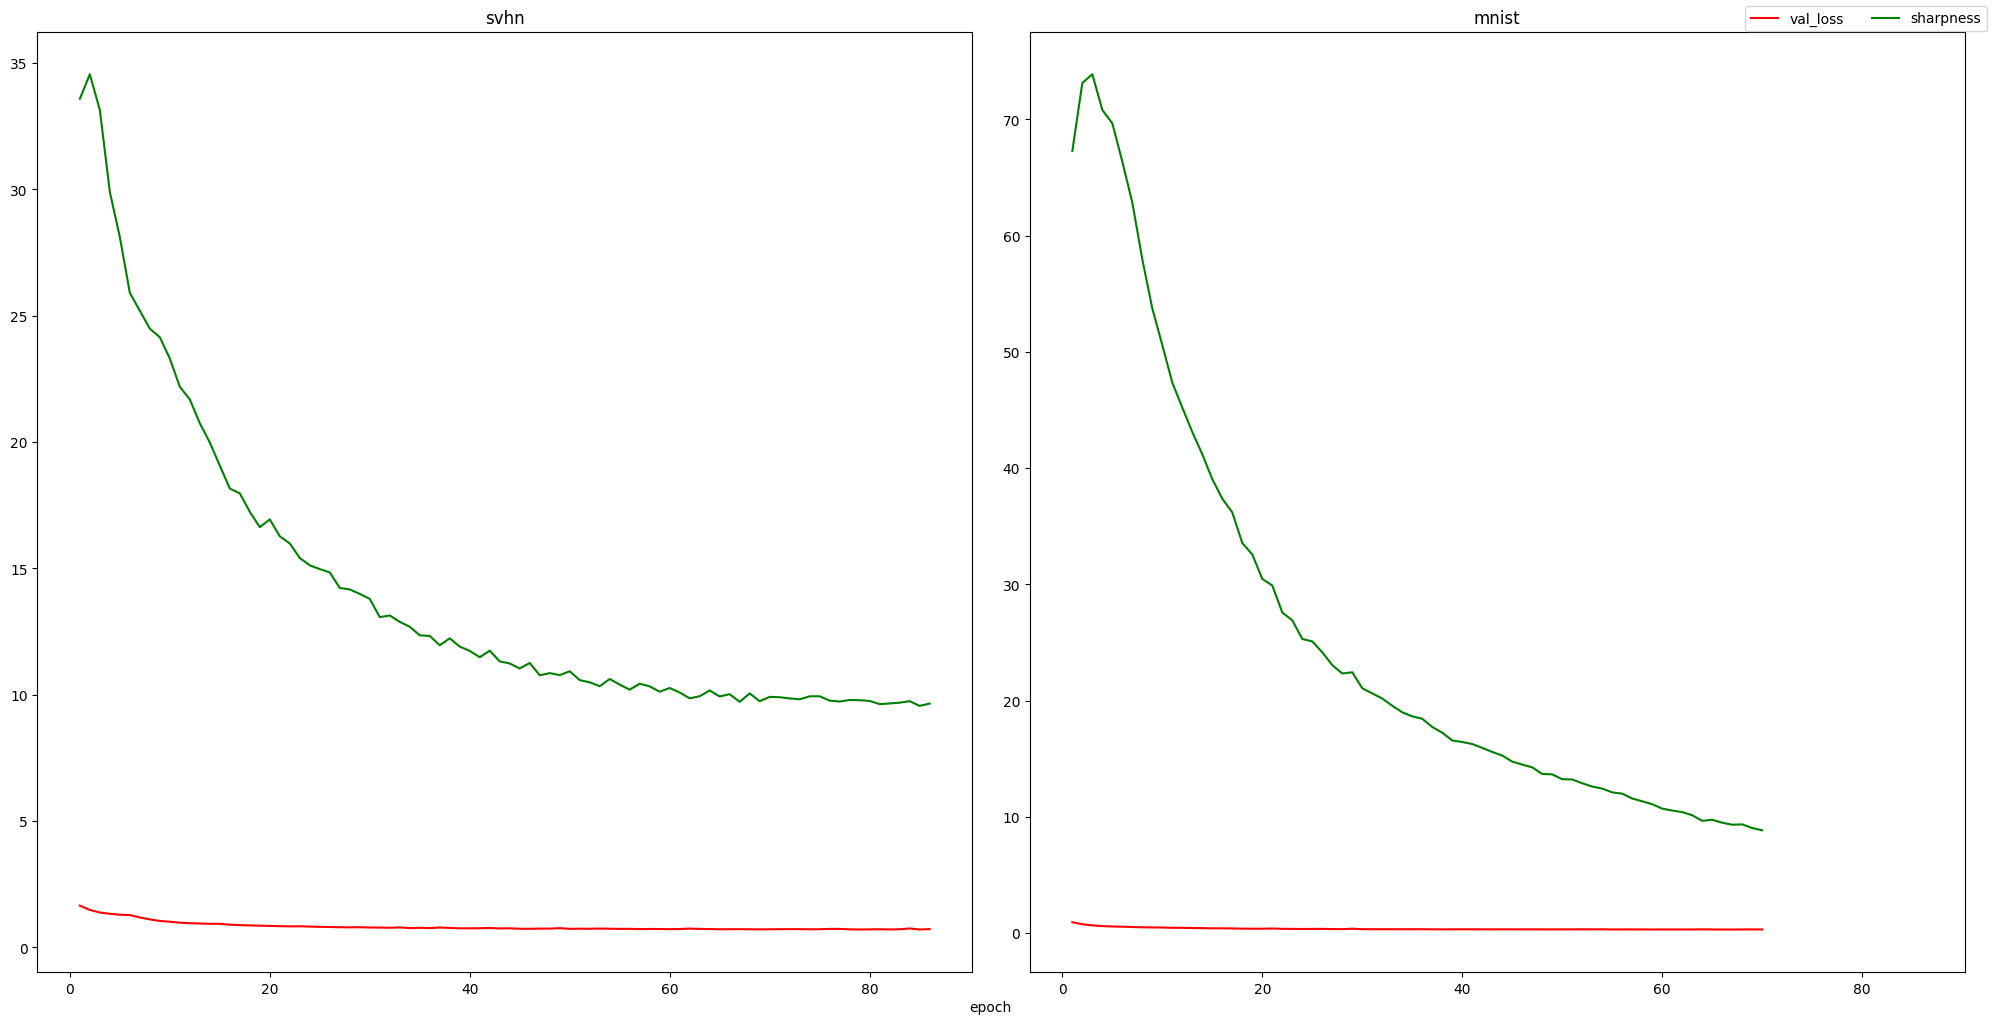

In [9]:
fig, ax = plt.subplots(1, 2, sharex=True, figsize=(20, 10), dpi=100)
fig.tight_layout()

fig.text(0.5, 0, "epoch", ha="center")

task_names = ["svhn", "mnist"]
for i, task_name in enumerate(task_names):
    gc.collect()
    history, mus = run_experiment(task_name, config)

    x = range(1, len(history["val_loss"]) + 1)
    ax[i].set_title(task_name)
    ax[i].plot(x, history["val_loss"], label="val_loss", color="r")
    ax[i].plot(x, mus, label="sharpness", color="g")

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [functools.reduce(operator.iadd, lol, []) for lol in zip(*lines_labels, strict=False)]

fig.legend(lines[:2], labels[:2], loc="upper right", ncol=2)

In [10]:
fig.savefig("image.svg")